# Additional scripts for plots and analysis

In [ ]:
import gseapy as gp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from gseapy import barplot, dotplot,  ringplot

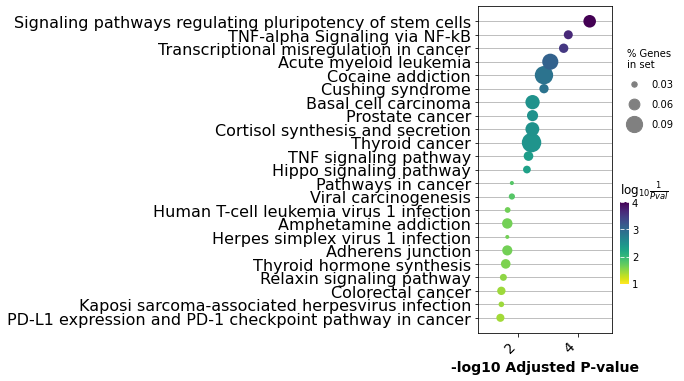

In [2]:
# start capital_test kernel to produce dotplots (due to matplotlib version conflict, under python3 kernel we cannot make dotplots)
with open('df_enrichr_top165DE_SPT.pkl', 'rb') as f:
    df = pickle.load(f)
df_top = df.sort_values('Adjusted P-value')[0:10]
# categorical scatterplot
df = df[0:15]
ax = dotplot(df,
              column="Adjusted P-value",
              x='-log10 Adjusted P-value', # set x axis, so you could do a multi-sample/library comparsion
              size=30,
              top_term=10,
              figsize=(3,6),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )
#plt.savefig('df_enrichr_top165DE_SPT.pdf',  bbox_inches='tight')

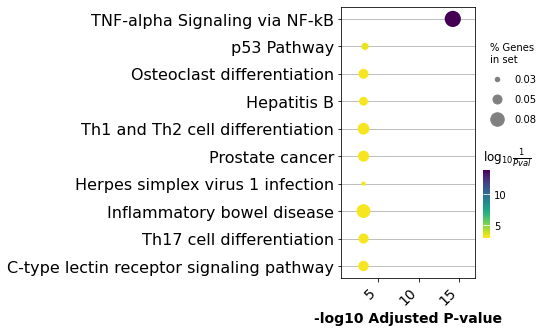

In [4]:
with open('df_enrichr_top120DE_CD8_DNonwards.pkl', 'rb') as f:
    df = pickle.load(f)
df_top = df.sort_values('Adjusted P-value')[0:10]
# categorical scatterplot
ax = dotplot(df_top,
              column="Adjusted P-value",
              x='-log10 Adjusted P-value', # set x axis, so you could do a multi-sample/library comparsion
              size=30,
              top_term=10,
              figsize=(3,5),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )
plt.savefig('df_enrichr_top120DE_CD8_DNonwards.pdf',  bbox_inches='tight')

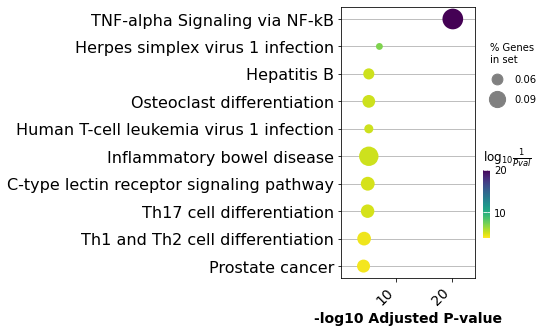

In [5]:
with open('df_enrichr_top130DE_SPT_DNonwards.pkl', 'rb') as f:
    df = pickle.load(f)
df_top = df.sort_values('Adjusted P-value')[0:10]
# categorical scatterplot
ax = dotplot(df_top,
              column="Adjusted P-value",
              x='-log10 Adjusted P-value', # set x axis, so you could do a multi-sample/library comparsion
              size=30,
              top_term=10,
              figsize=(3,5),
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )
plt.savefig('df_enrichr_top130DE_SPT_DNonwards.pdf',  bbox_inches='tight')

# CD8 vs. Type 1 innate T comparison

In [1]:
import anndata
import time 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
import pickle
from tqdm import tqdm
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import PathwayAnalyserV2
import VisualUtils
import matplotlib as mpl
import colorcet as cc

# Comparing SPT alignments to CD8 alignments
with open('Aligner_CD8_humanTFs_DNonwards_03012023_winsize0.1.pkl', 'rb') as f:
    aligner_cd8_010 = pickle.load(f)
with open('Aligner_SPT_humanTFs_DNonwards_24012023.pkl', 'rb') as f:
    aligner_spt_010 = pickle.load(f)


In [9]:
#ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner_cd8_010, DIST_THRESHOLD=40) 
#ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner_spt_010, DIST_THRESHOLD=40)

In [7]:
np.unique(df_cd8['match %']==100, return_counts=True)

(array([False,  True]), array([1008,  211]))

In [8]:
np.unique(df_spt['match %']==100, return_counts=True)

(array([False,  True]), array([1106,  114]))

In [9]:
print( len(aligner_spt.gene_list ) )
print( len(aligner_cd8.gene_list ) )

1220
1219


In [10]:
print(np.setdiff1d(aligner_cd8.gene_list,aligner_spt.gene_list ))
print(np.setdiff1d(aligner_spt.gene_list,aligner_cd8.gene_list )) 

['ARNT2' 'PRDM12' 'ZBTB32' 'ZBTB7C']
['IRF6' 'LBX2' 'POU5F1B' 'SOX10' 'ZNF541']


### Checking which TFs in Type 1 Innate T reference and CD8 reference are aligned differently against organoid query
(matched in one and mismatched in the other)

In [25]:
# Below is the ranked list of genes based on alignment percentage
aligner = aligner_cd8
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.5)
x = PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)
# We compute the Log2 fold change of their mean expression
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene])  )/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])
x_cd8 = x 

# Below is the ranked list of genes based on alignment percentage
aligner = aligner_spt
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.5)
x = PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)
# We compute the Log2 fold change of their mean expression
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene])  )/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])
x_spt = x 

156  # of DE genes to check
193  # of DE genes to check


In [26]:
x_spt['rank']= np.asarray(range(0,len(x_spt)))

In [27]:
x_cd8['rank']= np.asarray(range(0,len(x_cd8)))

In [9]:
from scipy import stats
import matplotlib.pyplot as plt

vega_20 = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728',
    '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
    '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
]
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

In [10]:
np.setdiff1d(x_cd8.index, x_spt.index)

array(['ARNT2', 'PRDM12', 'ZBTB32', 'ZBTB7C'], dtype=object)

In [11]:
np.setdiff1d(x_spt.index,x_cd8.index)

array(['IRF6', 'LBX2', 'POU5F1B', 'SOX10', 'ZNF541'], dtype=object)

In [28]:
l1 = list(x_cd8.index) # indices correspond to labels, eg A1, A2, A1, B1, ...
l2 = list(x_spt.index)
common = np.intersect1d(l1,l2)
temp = pd.DataFrame([x_cd8.loc[common]['rank'] - x_spt.loc[common]['rank'],  x_cd8.loc[common]['sim'] - x_spt.loc[common]['sim']  ,  x_cd8.loc[common]['abs_l2fc'], x_spt.loc[common]['abs_l2fc']  ]   ).transpose()
temp
temp.columns = ['rank_diff','sim_diff', 'abs_l2fc_cd8', 'abs_l2fc_spt']
temp = temp.sort_values(['sim_diff'], ascending=[False])
temp[temp.rank_diff==0]

,rank_diff,sim_diff,abs_l2fc_cd8,abs_l2fc_spt
Gene,,,,
ZNF609,0.0,0.0000,0.022257,0.062728
SNAI1,0.0,0.0000,8.883991,8.899989
MAFB,0.0,0.0000,4.541138,4.468393
ZNF703,0.0,-0.0427,4.671731,4.565544


In [29]:
# let's check sim % based on the last 6 alignment states spt=t1
last_stage_sims_spt = [] 
last_stage_sims_cd8 = []
# let's check l2fc of last stage between ref and ato for each spt and cd8 lineage
last_stage_l2fc_spt = [] # based on interpolated mean
last_stage_l2fc_cd8 = [] # based on interpolated mean
last_stage_l2fc_t1_cd8 = [] # based on interpolated mean

for g in temp.index:
    a = aligner_spt.results_map[g]
    t = a.alignment_str[::-1][0:6]
    if(a.S.mean_trend[14]<=0):
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[14]
         
    if(a.T.mean_trend[14]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[14]
    last_stage_l2fc_spt.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_spt.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
for g in temp.index:
    a = aligner_cd8.results_map[g]
    t = a.alignment_str[::-1][0:6]
    
    if(a.S.mean_trend[14]<=0):
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[14]
         
    if(a.T.mean_trend[14]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[14]
    last_stage_l2fc_cd8.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_cd8.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
# let's check l2fc of last stage between spt ref and cd8 ref
for g in temp.index:
    a_spt = aligner_spt.results_map[g]
    a_cd8 = aligner_cd8.results_map[g]
    
    if(a_spt.S.mean_trend[14]<=0):
        mean_spt_lastbin= 0.01
    else:
        mean_spt_lastbin = a_spt.S.mean_trend[14]
         
    if(a_cd8.S.mean_trend[14]<=0):
        mean_cd8_lastbin = 0.01
    else:
        mean_cd8_lastbin = a_cd8.S.mean_trend[14]
   # print(temp1,temp2)
    last_stage_l2fc_t1_cd8.append( np.log2(mean_spt_lastbin/mean_cd8_lastbin) )
    
temp['last_stage_sim_spt'] = last_stage_sims_spt
temp['last_stage_sim_cd8'] = last_stage_sims_cd8
temp['last_stage_l2fc_spt'] = last_stage_l2fc_spt
temp['last_stage_l2fc_cd8'] = last_stage_l2fc_cd8
temp['last_stage_sim_diff'] = np.asarray(last_stage_sims_spt) - np.asarray(last_stage_sims_cd8)
temp['last_stage_l2fc_diff'] = np.asarray(last_stage_l2fc_spt) - np.asarray(last_stage_l2fc_cd8)
temp['last_stage_l2fc_t1_cd8'] = last_stage_l2fc_t1_cd8 

# we are interested in high last bin alignment similarity diff between spt-ato and cd8-ato; and high l2fc between spt ref and cd8 ref
condition = np.logical_and(np.abs(temp['last_stage_sim_diff']) >= 0.5,np.abs(temp['last_stage_l2fc_t1_cd8'])>=0.5 )

t = temp[condition]
c=0
# filtering out genes which are less confident with low levels of gene expression
check_genes = []
for g in t.index: #AAAAA mean max
    if ( np.mean(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.mean(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

t.sort_values('last_stage_sim_diff', ascending=False)

,rank_diff,sim_diff,abs_l2fc_cd8,abs_l2fc_spt,last_stage_sim_spt,last_stage_sim_cd8,last_stage_l2fc_spt,last_stage_l2fc_cd8,last_stage_sim_diff,last_stage_l2fc_diff,last_stage_l2fc_t1_cd8
Gene,,,,,,,,,,,
ARID5B,-805.0,-0.3750,0.940331,0.770878,0.833333,0.000000,0.119630,-1.392374,0.833333,1.512004,1.511975
STAT3,-427.0,-0.0980,0.171048,0.147814,0.833333,0.166667,-0.150385,0.478741,0.666667,-0.629126,-0.629165
GATA3,-412.0,-0.1667,0.239699,0.148141,0.666667,0.000000,0.263614,-0.307817,0.666667,0.571431,0.571411
FOXP1,-376.0,-0.1667,0.541296,0.353138,0.500000,0.000000,0.478715,1.712610,0.500000,-1.233895,-1.233904
SOX4,-263.0,-0.3289,0.906394,0.929832,0.500000,0.000000,0.149892,1.722049,0.500000,-1.572157,-1.572169
BHLHE40,229.0,0.3479,2.013620,1.566978,0.000000,0.500000,2.196228,0.134911,-0.500000,2.061317,2.061308
IKZF1,406.0,0.2647,0.425725,0.489677,0.000000,1.000000,-0.808480,-0.040694,-1.000000,-0.767786,-0.767812


<AxesSubplot:xlabel='last_stage_sim_diff', ylabel='Count'>

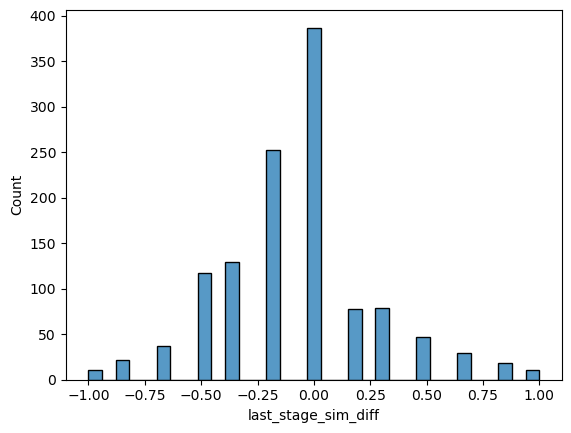

In [30]:
sb.histplot(temp['last_stage_sim_diff']) # spt % - cd8 %

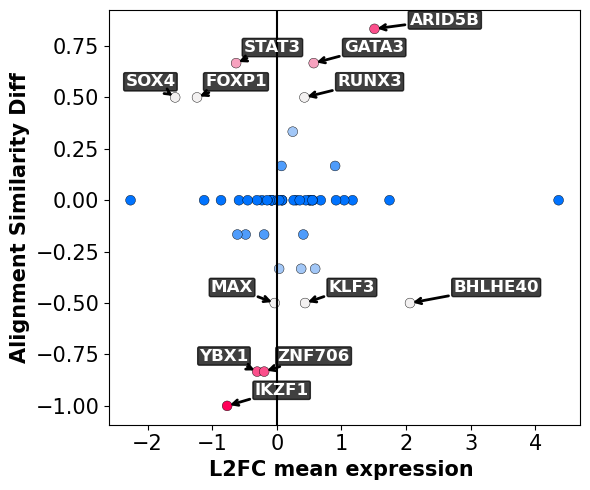

In [31]:
# PLOT volcan like ---- don't filter l2fc but below 
from adjustText import adjust_text

t = temp
c=0
check_genes = []
for g in t.index:#AAAA mean max
    if ( np.mean(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.mean(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

most_DE_genes = t.index
plt.subplots(1,1,figsize=(6,5))
x = t
ax=sb.scatterplot(x['last_stage_l2fc_t1_cd8'],x['last_stage_sim_diff'],s=50, legend=False, hue =np.abs(x['last_stage_sim_diff']) ,palette=sb.diverging_palette(255, 0, s=150, as_cmap=True),edgecolor='k',linewidth=0.3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Alignment Similarity Diff', fontsize=15, fontweight='bold')
# Log2 fold change of mean expression in Type 1 Innate T and CD8 reference last bins
plt.xlabel('L2FC mean expression ', fontsize = 15, fontweight='bold')
plt.grid(False)
plt.axvline(0,0,1.0, color='k')

TEXTS = [] 
for i, gene in enumerate (x.index):
    if( np.abs(x['last_stage_sim_diff'][i])>=0.5):
        TEXTS.append(ax.text(x['last_stage_l2fc_diff'][i], x['last_stage_sim_diff'][i], x.index[i], color='white', fontsize=12, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))

plt.tight_layout()
#plt.savefig('volcano_like_plot_cd8_t1_diff.pdf')

In [23]:
# let's check sim % based on the last 6 alignment states spt=t1
last_stage_sims_spt = [] 
last_stage_sims_cd8 = []
# let's check l2fc of last stage between ref and ato for each spt and cd8 lineage
last_stage_l2fc_spt = [] # based on interpolated mean
last_stage_l2fc_cd8 = [] # based on interpolated mean
last_stage_l2fc_t1_cd8 = [] # based on interpolated mean

for g in temp.index:
    a = aligner_spt.results_map[g]
    t = a.alignment_str[::-1][0:6]
    if(a.S.mean_trend[14]<=0):
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[14]
         
    if(a.T.mean_trend[14]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[14]
    last_stage_l2fc_spt.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_spt.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
for g in temp.index:
    a = aligner_cd8.results_map[g]
    t = a.alignment_str[::-1][0:6]
    
    if(a.S.mean_trend[14]<=0):
        mean_S_lastbin = 0.01
    else:
         mean_S_lastbin  = a.S.mean_trend[14]
         
    if(a.T.mean_trend[14]<=0):
        mean_T_lastbin  = 0.01
    else:
        mean_T_lastbin  = a.T.mean_trend[14]
    last_stage_l2fc_cd8.append( np.log2(mean_S_lastbin/mean_T_lastbin) )
    last_stage_sims_cd8.append((t.count('M') + t.count('W') + t.count('V'))/6) 
    
# let's check l2fc of last stage between spt ref and cd8 ref
for g in temp.index:
    a_spt = aligner_spt.results_map[g]
    a_cd8 = aligner_cd8.results_map[g]
    
    if(a_spt.S.mean_trend[14]<=0):
        mean_spt_lastbin= 0.01
    else:
        mean_spt_lastbin = a_spt.S.mean_trend[14]
         
    if(a_cd8.S.mean_trend[14]<=0):
        mean_cd8_lastbin = 0.01
    else:
        mean_cd8_lastbin = a_cd8.S.mean_trend[14]
   # print(temp1,temp2)
    last_stage_l2fc_t1_cd8.append( np.log2(mean_spt_lastbin/mean_cd8_lastbin) )
    
temp['last_stage_sim_spt'] = last_stage_sims_spt
temp['last_stage_sim_cd8'] = last_stage_sims_cd8
temp['last_stage_l2fc_spt'] = last_stage_l2fc_spt
temp['last_stage_l2fc_cd8'] = last_stage_l2fc_cd8
temp['last_stage_sim_diff'] = np.asarray(last_stage_sims_spt) - np.asarray(last_stage_sims_cd8)
temp['last_stage_l2fc_diff'] = np.asarray(last_stage_l2fc_spt) - np.asarray(last_stage_l2fc_cd8)
temp['last_stage_l2fc_t1_cd8'] = last_stage_l2fc_t1_cd8 

# we are interested in high last bin alignment similarity diff between spt-ato and cd8-ato; and high l2fc between spt ref and cd8 ref
condition = np.logical_and(np.abs(temp['last_stage_sim_diff']) >= 0.5,np.abs(temp['last_stage_l2fc_t1_cd8'])>=0.5 )

t = temp[condition]
c=0
# filtering out genes which are less confident with low levels of gene expression
check_genes = []
for g in t.index:
    if ( np.max(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.max(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

t.sort_values('last_stage_sim_diff', ascending=False)

,rank_diff,sim_diff,abs_l2fc_cd8,abs_l2fc_spt,last_stage_sim_spt,last_stage_sim_cd8,last_stage_l2fc_spt,last_stage_l2fc_cd8,last_stage_sim_diff,last_stage_l2fc_diff,last_stage_l2fc_t1_cd8
Gene,,,,,,,,,,,
ARID5B,-805.0,-0.3750,0.940331,0.770878,0.833333,0.000000,0.119630,-1.392374,0.833333,1.512004,1.511975
STAT3,-427.0,-0.0980,0.171048,0.147814,0.833333,0.166667,-0.150385,0.478741,0.666667,-0.629126,-0.629165
GATA3,-412.0,-0.1667,0.239699,0.148141,0.666667,0.000000,0.263614,-0.307817,0.666667,0.571431,0.571411
FOXP1,-376.0,-0.1667,0.541296,0.353138,0.500000,0.000000,0.478715,1.712610,0.500000,-1.233895,-1.233904
SOX4,-263.0,-0.3289,0.906394,0.929832,0.500000,0.000000,0.149892,1.722049,0.500000,-1.572157,-1.572169
BHLHE40,229.0,0.3479,2.013620,1.566978,0.000000,0.500000,2.196228,0.134911,-0.500000,2.061317,2.061308
IKZF1,406.0,0.2647,0.425725,0.489677,0.000000,1.000000,-0.808480,-0.040694,-1.000000,-0.767786,-0.767812


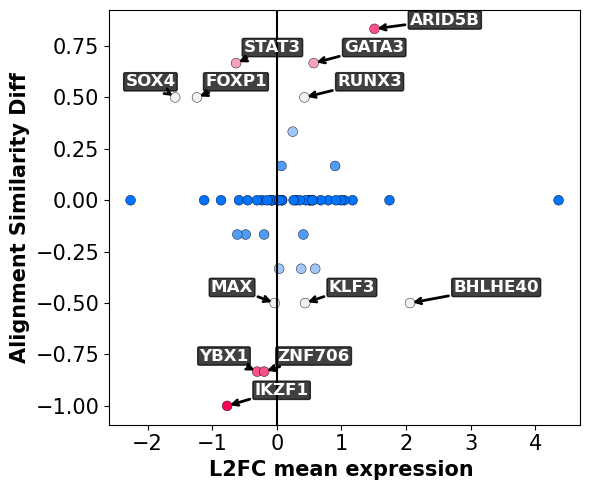

In [24]:
# PLOT volcan like ---- don't filter l2fc but below 
from adjustText import adjust_text

t = temp
c=0
check_genes = []
for g in t.index:
    if ( np.max(aligner_spt.results_map[g].S.mean_trend[11:15]) < 0.5 and np.max(aligner_cd8.results_map[g].S.mean_trend[11:15] < 0.5)):
        c+=1
    else:
        check_genes.append(g)
t= t.loc[check_genes].sort_values('last_stage_sim_diff')

most_DE_genes = t.index
plt.subplots(1,1,figsize=(6,5))
x = t
ax=sb.scatterplot(x['last_stage_l2fc_t1_cd8'],x['last_stage_sim_diff'],s=50, legend=False, hue =np.abs(x['last_stage_sim_diff']) ,palette=sb.diverging_palette(255, 0, s=150, as_cmap=True),edgecolor='k',linewidth=0.3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('Alignment Similarity Diff', fontsize=15, fontweight='bold')
# Log2 fold change of mean expression in Type 1 Innate T and CD8 reference last bins
plt.xlabel('L2FC mean expression ', fontsize = 15, fontweight='bold')
plt.grid(False)
plt.axvline(0,0,1.0, color='k')

TEXTS = [] 
for i, gene in enumerate (x.index):
    if( np.abs(x['last_stage_sim_diff'][i])>=0.5):
        TEXTS.append(ax.text(x['last_stage_l2fc_diff'][i], x['last_stage_sim_diff'][i], x.index[i], color='white', fontsize=12, fontweight='bold',bbox=dict(boxstyle='round,pad=0.1', fc='black', alpha=0.75)))
adjust_text(TEXTS, expand_points=(2, 2),arrowprops=dict(arrowstyle="->", color='black', lw=2))

plt.tight_layout()
plt.savefig('volcano_like_plot_cd8_t1_diff.pdf')

In [93]:
adata_ref_spt = anndata.read_h5ad('PanfetalATO_SPT_DNonwards_gplvm_ref_24012023.h5ad')
adata_ref_cd8 = anndata.read_h5ad('PanfetalATO_CD8_DNonwards_gplvm_ref_24012023.h5ad')
adata_query_ato1 = anndata.read_h5ad('PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad')

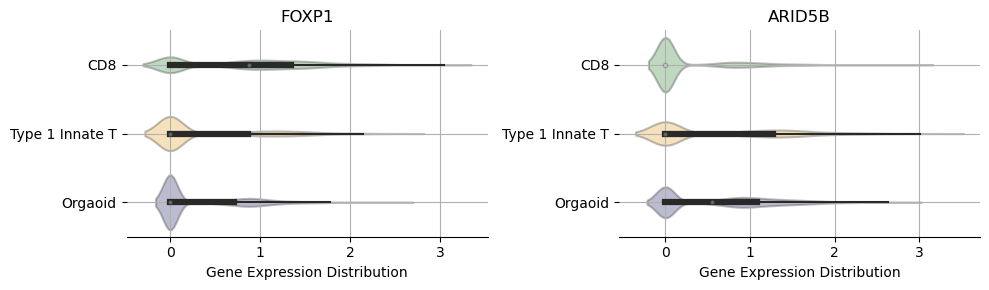

In [139]:
def plot_violin(gene, R,Q,ato):
    ref_data = list(np.asarray(R[:,gene].X.todense()).flatten()) 
    query_data = list(np.asarray(Q[:,gene].X.todense()).flatten())
    ato_data = list(np.asarray(ato[:,gene].X.todense()).flatten())

    df = pd.DataFrame([ref_data+ query_data+ato_data,list(np.repeat('CD8', len(ref_data))) + list(np.repeat('Type 1 Innate T', len(query_data)))
                      + list(np.repeat('Orgaoid', len(ato_data)))
                      ]).transpose()
    df.columns = ['expr','system']
    df['expr'] = np.asarray(df['expr'], dtype=float)
    ax = sb.violinplot(data=df, x='expr',y='system', palette=['forestgreen','orange','midnightblue'], alpha=0.1) 
    plt.setp(ax.collections, alpha=.3)
    plt.ylabel('')
    plt.xlabel('Gene Expression Distribution')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    plt.grid('off')
    plt.title(gene)
    
    return ref_data, query_data, ato_data
    
# checking the last 2 bins
import matplotlib as mpl
mpl.style.use('default')
k=2
last_2bin_ref_cd8 = adata_ref_cd8[[i in np.arange(15-k,15) for i in adata_ref_cd8.obs.bin_ids]]
last_2bin_ref_spt = adata_ref_spt[[i in np.arange(15-k,15) for i in adata_ref_spt.obs.bin_ids]]
last_2bin_ref_ato = adata_query_ato1[[i in np.arange(15-k,15) for i in adata_query_ato1.obs.bin_ids]]

# CHECKING ALL relevant cell type expression that makes into the last bins
last_2bin_ref_cd8 = adata_ref_cd8[adata_ref_cd8.obs.ANNOTATION_COMB=='CD8+T']
last_2bin_ref_spt = adata_ref_spt[adata_ref_spt.obs.ANNOTATION_COMB=='TYPE_1_INNATE_T']
last_2bin_ref_ato = adata_query_ato1[adata_query_ato1.obs.ANNOTATION_COMB=='SP_T']

plt.subplots(1,2,figsize=(10,3))
plt.subplot(1,2,1)
plot_violin('FOXP1', last_2bin_ref_cd8, last_2bin_ref_spt,last_2bin_ref_ato)
plt.subplot(1,2,2)
plot_violin('ARID5B', last_2bin_ref_cd8, last_2bin_ref_spt,last_2bin_ref_ato)
plt.tight_layout()

In [138]:
adata_ref_cd8[adata_ref_cd8.obs.ANNOTATION_COMB=='CD8+T']
adata_ref_spt[adata_ref_spt.obs.ANNOTATION_COMB=='TYPE_1_INNATE_T']
adata_query_ato1[adata_query_ato1.obs.ANNOTATION_COMB=='SP_T']

View of AnnData object with n_obs × n_vars = 6558 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

Mean gene expression in last 2 bins
CD8: 0.8057391
Type 1 Innate T:  0.3560049
Orgnaoid: 0.30461252


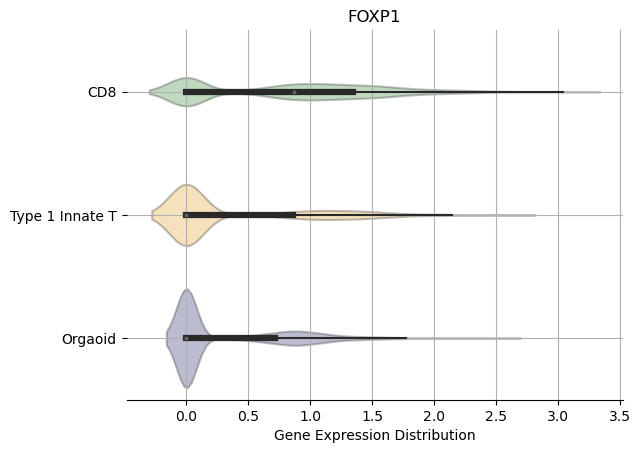

In [140]:
ref_data, query_data, ato_data = plot_violin('FOXP1', last_2bin_ref_cd8, last_2bin_ref_spt,last_2bin_ref_ato)
print('Mean gene expression in last 2 bins')
print('CD8:', np.mean(ref_data) )
print('Type 1 Innate T: ', np.mean(query_data) )
print( 'Orgnaoid:', np.mean(ato_data) )

Mean gene expression in last 2 bins
CD8: 0.23623285
Type 1 Innate T:  0.59550774
Orgnaoid: 0.59124327


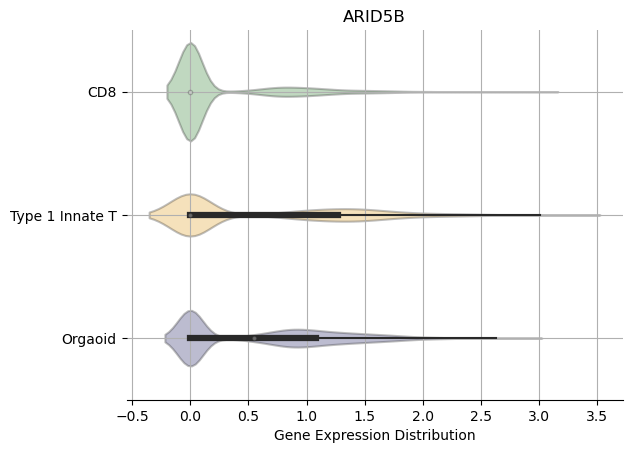

In [141]:
ref_data, query_data, ato_data = plot_violin('ARID5B', last_2bin_ref_cd8, last_2bin_ref_spt,last_2bin_ref_ato)
print('Mean gene expression in last 2 bins')
print('CD8:', np.mean(ref_data) )
print('Type 1 Innate T: ', np.mean(query_data) )
print( 'Orgnaoid:', np.mean(ato_data) )

In [131]:
np.mean(ato_data) 

0.27431905

In [114]:
last_2bin_ref_ato

View of AnnData object with n_obs × n_vars = 243 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [115]:
last_2bin_ref_cd8

View of AnnData object with n_obs × n_vars = 338 × 17696
    obs: 'ANNOTATION_COMB', 'time', 'bbk', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [116]:
last_2bin_ref_spt

View of AnnData object with n_obs × n_vars = 202 × 17718
    obs: 'ANNOTATION_COMB', 'time', 'bbk', 'n_counts', 'refined_time', 'bin_ids'
    var: 'n_cells'
    uns: 'ANNOTATION_COMB_colors', 'log1p'
    obsm: 'X_gplvm', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Additional plot to visualise MML distance function

In [2]:
import anndata
import time 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
import os,sys,inspect
import pickle
from tqdm import tqdm
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 
# new source imports 
import OrgAlign as orgalign
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import ClusterUtils
import PathwayAnalyserV2
import VisualUtils
import matplotlib as mpl
import torch
torch.manual_seed(1)
datasets = [] 
mean_range = np.linspace(0,9.0,50)
for mu in mean_range:
    datasets.append(MyFunctions.generate_random_dataset(5000,mu,1.0)[0])

In [5]:
def compute_mmldist(gex1,gex2):
    
        μ_S = np.mean(gex1); σ_S = np.std(gex1); 
        μ_T = np.mean(gex2); σ_T = np.std(gex2); 
        
        ref_data = gex1 
        query_data = gex2

        I_ref_model, I_refdata_g_ref_model = MyFunctions.run_dist_compute_v3(ref_data, μ_S, σ_S) 
        I_query_model, I_querydata_g_query_model = MyFunctions.run_dist_compute_v3(query_data, μ_T, σ_T) 
        I_ref_model, I_querydata_g_ref_model = MyFunctions.run_dist_compute_v3(query_data, μ_S, σ_S) 
        I_query_model, I_refdata_g_query_model = MyFunctions.run_dist_compute_v3(ref_data, μ_T, σ_T) 
        
        match_encoding_len1 = I_ref_model + I_querydata_g_ref_model + I_refdata_g_ref_model
        match_encoding_len1 = match_encoding_len1/(len(query_data)+len(ref_data))
        match_encoding_len2 = I_query_model + I_refdata_g_query_model + I_querydata_g_query_model
        match_encoding_len2 = match_encoding_len2/(len(query_data)+len(ref_data))
        match_encoding_len = (match_encoding_len1 + match_encoding_len2 )/2.0 
        
        null = (I_ref_model + I_refdata_g_ref_model + I_query_model + I_querydata_g_query_model)/(len(query_data)+len(ref_data))
        match_compression =   match_encoding_len - null 

        return round(float(match_compression.numpy()),4) 

def single_gene_plot(data, color):
    p = sb.kdeplot(data, fill=True, color=color, linewidth=3.0, ) # datasets[i] represents gene expression distribution at timepoint i
    sb.despine(bottom = True, left = True)
    p.set(xticklabels=[])
    p.set(yticklabels=[])
    p.set(xticks=[])
    p.set(yticks=[])
    plt.ylabel('')
    plt.show()

# i,j are timepoints
def run_gene_comparison(i, j, filename=''):
    sb.kdeplot(datasets[i], fill=True, color='forestgreen', linewidth=3.0) # datasets[i] represents gene expression distribution at timepoint i
    sb.kdeplot(datasets[j], fill=True, color='midnightblue', linewidth=3.0) # datasets[j] represents gene expression distribution at timepoint j
  #  plt.legend(['Reference','Query'])
    if(len(filename)>0):
        plt.savefig('../'+filename+'.pdf')

    return compute_mmldist(datasets[i], datasets[j])


#run_gene_comparison(0,0)
#single_gene_plot(datasets[0],'forestgreen')
#single_gene_plot(datasets[5],'midnightblue')

-0.001

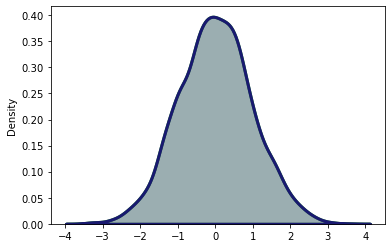

In [9]:
run_gene_comparison(0,0, filename='ZZZ_eg0')

0.2148

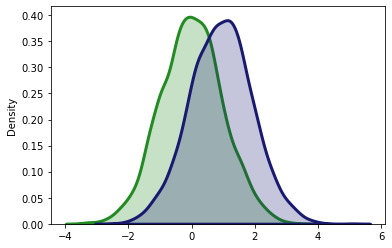

In [10]:
run_gene_comparison(0,5, filename='ZZZ_eg1')

1.9572

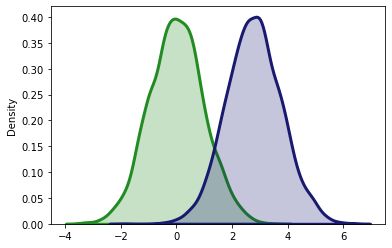

In [11]:
run_gene_comparison(0,15, filename='ZZZ_eg2')

17.1586

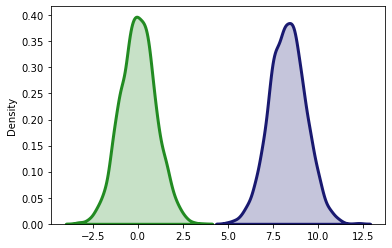

In [12]:
run_gene_comparison(0,45, filename='ZZZ_eg3')

100%|██████████| 50/50 [00:00<00:00, 375.26it/s]


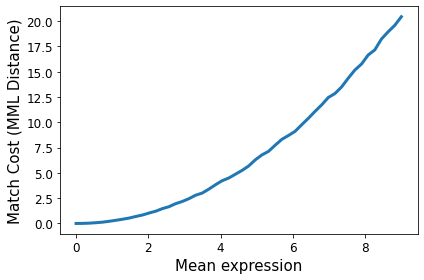

In [14]:
dists = []
for i in tqdm(range(0,len(datasets))):
    dists.append(compute_mmldist(datasets[0], datasets[i])) 

sb.lineplot(mean_range, dists, linewidth=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Match Cost (MML Distance)', fontsize=15)
plt.xlabel('Mean expression',fontsize=15)
plt.tight_layout()
plt.savefig('MML_distance_function.png')


In [76]:
# Std different distributions

In [22]:
torch.manual_seed(1)
var_datasets = [] 
std_range = np.linspace(0.1,3.0,50)
for std in std_range:
    var_datasets.append(MyFunctions.generate_random_dataset(5000,0.0,std)[0])

In [23]:
datasets = var_datasets

-0.0012

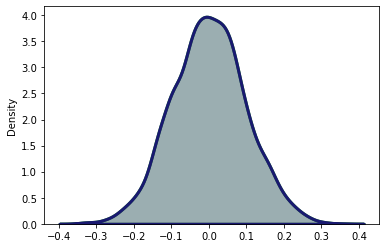

In [24]:
run_gene_comparison(0,0)

0.1172

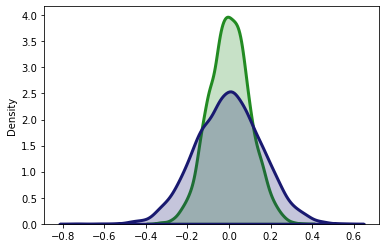

In [25]:
run_gene_comparison(0,1, filename='ZZZstd_eg1')

1.7367

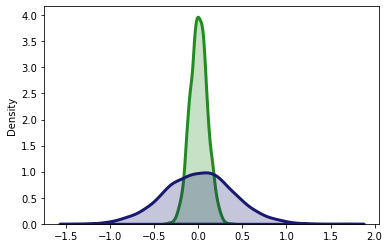

In [26]:
run_gene_comparison(0,5, filename='ZZZstd_eg2')

32.5647

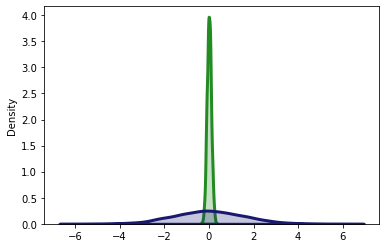

In [27]:
run_gene_comparison(0,25, filename='ZZZstd_eg3')

100%|██████████| 50/50 [00:00<00:00, 355.22it/s]


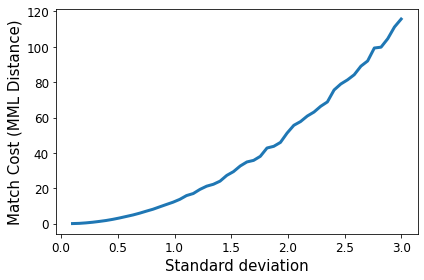

In [28]:
dists = []
for i in tqdm(range(0,len(datasets))):
    dists.append(compute_mmldist(datasets[0], datasets[i])) 
sb.lineplot(std_range, dists, linewidth=3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Match Cost (MML Distance)', fontsize=15)
plt.xlabel('Standard deviation',fontsize=15)
plt.tight_layout()
plt.savefig('MML_distance_function_const_mean0_var_std.png')


In [29]:
torch.manual_seed(1)
comb_datasets = {} 
mean_range = np.linspace(0,9.0,50)
std_range = np.linspace(0.1,3.0,50)
for std in std_range:
    for mean in mean_range:
        comb_datasets[(mean,std)] = MyFunctions.generate_random_dataset(5000,mean,std)[0]

(0.5510204081632654, 0.39591836734693875)
(0.7346938775510204, 0.6918367346938775)


0.1953

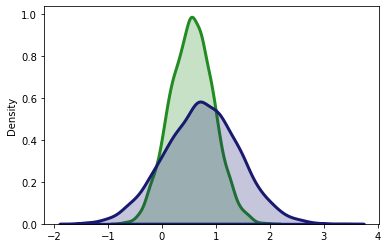

In [30]:
comb_datasets[(mean_range[3],std_range[5])]
comb_datasets[(mean_range[4],std_range[10])]


# i,j are timepoints
def run_gene_comparison(i, j,filename=''):
    print(i)
    print(j)
    sb.kdeplot(comb_datasets[i], fill=True, color='forestgreen', linewidth=3.0) # datasets[i] represents gene expression distribution at timepoint i
    sb.kdeplot(comb_datasets[j], fill=True, color='midnightblue', linewidth=3.0) # datasets[j] represents gene expression distribution at timepoint j
  #  plt.legend(['Reference','Query'])
    if(len(filename)>0):
        plt.savefig('../'+filename+'.pdf')

    return compute_mmldist(comb_datasets[i], comb_datasets[j])

run_gene_comparison((mean_range[3],std_range[5]),(mean_range[4],std_range[10]), filename='ZZZ_both_eg1')

#run_gene_comparison(0,0)
#single_gene_plot(datasets[0],'forestgreen')
#single_gene_plot(datasets[5],'midnightblue')

(2.3877551020408165, 0.9877551020408162)
(5.510204081632653, 1.3428571428571427)


1.9226

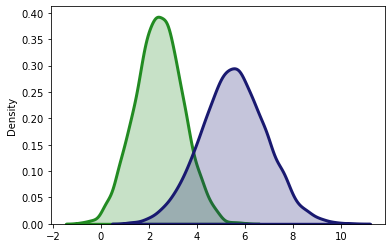

In [31]:
run_gene_comparison((mean_range[13],std_range[15]),(mean_range[30],std_range[21]), filename='ZZZ_both_eg2')

(0.1836734693877551, 2.4081632653061225)
(8.26530612244898, 1.3428571428571427)


6.0353

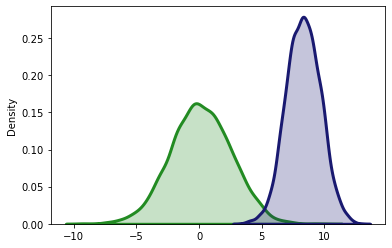

In [32]:
run_gene_comparison((mean_range[1],std_range[39]),(mean_range[45],std_range[21]), filename='ZZZ_both_eg3')